Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Provide full answers for each question, including interpretation of the results. Each question is worth 25 points.

This homework is due on Friday, December 8, 2017.

## Question 1

The `titanic.xls` spreadsheet in the `data` directory contains data regarding the passengers on the Titanic when it sank in 1912. A recent [Kaggle competition](http://www.kaggle.com/c/titanic-gettingStarted) was based on predicting survival for passengers based on the attributes in the passenger list. 

Use scikit-learn to build both a support vector classifier and a logistic regression model to predict survival on the Titanic. Use cross-validation to assess your models, and try to tune them to improve performance.

Discuss the benefits and drawbacks of both approaches for application to such problems.

In [172]:
# Write your work here

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [173]:
titanic = pd.read_excel('../data/titanic.xls',"titanic")


In [174]:
#deal with some predictors
#reference: Kaggle. I looked at what others do with the sibsp, parch and title part

#change cabin to whether has cabin or not
titanic['has_cabin'] = titanic["cabin"].apply(lambda x: 0 if type(x) == float else 1)
#get number of family members for each guest
titanic['familysize'] = titanic['sibsp'] + titanic['parch'] + 1
import re
#get the social status information from name
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
titanic['title'] = titanic['name'].apply(get_title)
titanic['Title'] = titanic['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic['title'] = titanic['title'].replace(['Mlle','Ms'], 'Miss')
titanic['title'] = titanic['title'].replace('Mme', 'Mrs')

titanic['title'] = titanic['title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
titanic['title'] = titanic['title'].fillna(0)



In [175]:
#drop several columns 
titanic_data = titanic.drop(['name','ticket','cabin','boat','body','Title','home.dest'], axis = 1)
titanic_data=titanic_data.dropna(axis=0,how='any')

#change embarked to numbers
titanic_data['embarked'] = titanic_data.embarked.replace({'S':0, 'C':1,'Q':2})
#change sex to numbers 
titanic_data['sex'] = titanic_data.sex.replace({'male':0, 'female':1})

In [176]:
y =titanic_data.pop('survived')
X=titanic_data.copy()

## logistic regression

In [177]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
from sklearn.linear_model import LogisticRegression

#logistic regression
lrmod = LogisticRegression(C=1000) 
lrmod

lrmod.fit(X_train, y_train)

pred_train = lrmod.predict(X_train)
pred_test = lrmod.predict(X_test)

#use cross validation to assess model performance
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

lrscores = model_selection.cross_val_score(lrmod, X, y, cv=10)
lrscores

array([ 0.6       ,  0.78095238,  0.87619048,  0.86666667,  0.83809524,
        0.83653846,  0.91346154,  0.65384615,  0.68932039,  0.74757282])

In [178]:
print("logistic regression Accuracy: %0.2f (+/- %0.2f)" % (lrscores.mean(), lrscores.std() * 2))

logistic regression Accuracy: 0.78 (+/- 0.20)


In [179]:
#with training data
pd.crosstab(y_train, pred_train, 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,395,68
1,74,245


In [180]:
#with test data
pd.crosstab(y_test, pred_test, 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,131,24
1,29,77


## support vector machine

In [181]:
#use support vector machine (SVM)
from sklearn import svm
f = svm.SVC(kernel='linear', C=1)
f.fit(X_train, y_train)
f.score(X_test, y_test)

#use cross validation to assess model performance
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

scores = model_selection.cross_val_score(f, X, y, cv=10)
scores

array([ 0.65714286,  0.85714286,  0.85714286,  0.83809524,  0.82857143,
        0.83653846,  0.85576923,  0.71153846,  0.66990291,  0.75728155])

In [182]:
print("SVM Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

SVM Accuracy: 0.79 (+/- 0.15)


compare logistic regression and SVM:
using 10-fold cross validation, we see the mean accuracy score of logistic regression (c=1000) is 0.78, mean accuracy socre for SVM(linear, c=1) is 0.79. So they perform similarly here.

Let n=number of features, m=number of training samples
Generally, it is suggested if 
n is large compare to m, use logistic regression or linear SVM
n is small, m is intermediate, use SVM (gaussian kernal)
n is small, m is large, add more features then use use logistic regression or linear SVM

Here we have a dataset of large m (sample), small n (feature), so we use logistic regression or linear SVM. But here logistic regression is more appropriate

Logistic regression
benefits: robust to small noises
drawbacks: Doesn’t perform well when feature space is too large, use entire data

SVM
benefits: leads to sparser solutions, Can handle large feature space, doesn't need entire data
drawbacks: Not very efficient with large number of observations (situation here), need specify kernal (can be triky)

reference: https://www.edvancer.in/logistic-regression-vs-decision-trees-vs-svm-part2/


## Question 2

The file `TNNASHVI.txt` in your data directory contains daily temperature readings for Nashville, courtesy of the [Average Daily Temperature Archive](http://academic.udayton.edu/kissock/http/Weather/). This data, as one would expect, oscillates annually. Using PyMC3, use a Gaussian process to fit a non-parametric regression model to this data, choosing an appropriate covariance function. Plot 10 regression lines drawn from your process.

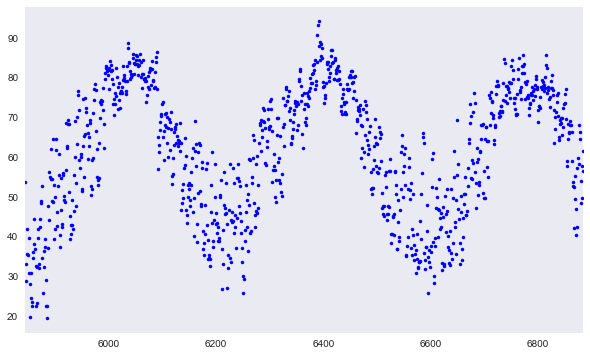

In [183]:
%matplotlib inline

import pandas as pd

daily_temps = pd.read_table("../data/TNNASHVI.txt", sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)

#use data after 2010
temps_2010 = daily_temps.temp[daily_temps.year>2010]
temps_2010.plot(style='b.', figsize=(10,6), grid=False)

x, y = temps_2010.reset_index().values.T
X = x.reshape(-1, 1)

In [184]:
daily_temps = pd.read_table("../data/TNNASHVI.txt", sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)

# Transmogrify data
y = daily_temps.temp[daily_temps.year>2010]
X = np.atleast_2d(np.arange(len(y))).T

In [185]:

#PyMC3 , choose cosine covariance here 
import pymc3 as pm

with pm.Model() as temp_model:
    
   #use cosine covariance here
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Cosine(1, l)
    
    M = pm.gp.mean.Linear(coeffs=(y/X).mean())
    
    σ = pm.HalfCauchy('σ', 1)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=cov)
    
    recruit_gp.marginal_likelihood('temparature', X=X, 
                           y=y, noise=σ)
    



Exception: Data must be 1-dimensional

In [12]:
with temp_model:
    temp_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
100%|██████████| 1500/1500 [30:05<00:00,  1.05it/s] 


In [18]:
np.max(X)

6885.0

In [19]:
np.min(X)

5844.0

In [20]:
X_pred = np.linspace(5800, 6900, 100).reshape(-1, 1)
with temp_model:
    temp_pred = recruit_gp.conditional("temp_pred", X_pred)
    temp_samples = pm.sample_ppc(temp_trace, vars=[temp_pred], samples=10)

100%|██████████| 10/10 [00:04<00:00,  3.84it/s]


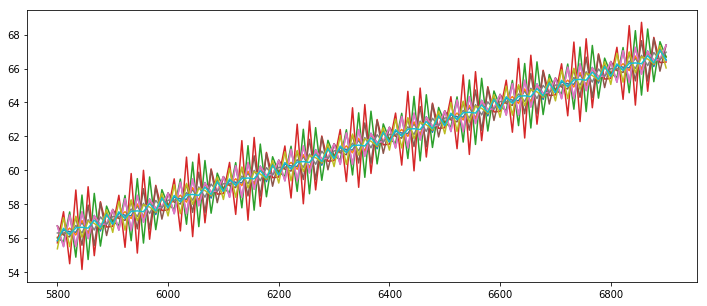

In [24]:
#plot 10 regression lines drawn from your process
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

for x in temp_samples['temp_pred']:
    ax.plot(X_pred, x);

## Question 3

Fit a series of random-forest classifiers to the Wisconsin breast cancer dataset (`wisconsin_breast_cancer.csv`), to explore the sensitivity to the parameters `max_features`, the number of variables considered for splitting at each step, `max_depth`, the maximum depth of the tree, and `n_estimators`, the number of trees in the forest. Use apprpriate metrics of performance, and include plots against a suitably-chosen range of values for these parameters.

Dataset description: Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. Ten real-valued features are computed for each cell nucleus:

- `radius` (mean of distances from center to points on the perimeter) 
- `texture` (standard deviation of gray-scale values) 
- `perimeter` 
- `area` 
- `smoothness` (local variation in radius lengths) 
- `compactness` (perimeter^2 / area - 1.0) 
- `concavity` (severity of concave portions of the contour) 
- `concave points` (number of concave portions of the contour) 
- `symmetry` 
- `fractal dimension` ("coastline approximation" - 1)

The outcome to be predicted is tumor type (M = malignant, B = benign).

In [188]:
# Write your work here
bc=pd.read_csv("../data/wisconsin_breast_cancer.csv")

In [189]:
bc.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [190]:
y=bc.pop('diagnosis')

In [191]:
X=bc.iloc[:,1:32]

In [192]:
from sklearn import tree
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier



/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

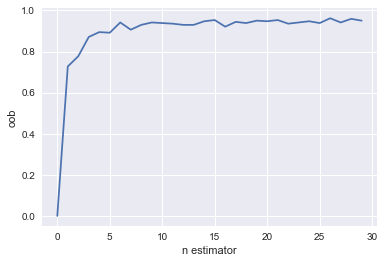

In [152]:
#include plots against a suitably-chosen range of values for these parameters
#use oob score as measure of performance
#n_estimators
def rfscore_nest(X,y,M=30):
    score = np.zeros(M)
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=0.4, random_state=0)
    
    for m in np.arange(1,M):
        value=m
        rf = RandomForestClassifier(n_jobs=20, n_estimators=value,bootstrap=True, criterion='entropy',oob_score=True)
        rf.fit(X_train, y_train)
        preds = rf.predict(X_test)
        #pd.crosstab(y_test, preds, rownames=['actual'], 
           # colnames=['prediction'])
        score[value]=rf.oob_score_
    #return score

    plt.plot(range(M), score)
    plt.xlabel('n estimator')
    plt.ylabel('oob')
    
rfscore_nest(X,y)

/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

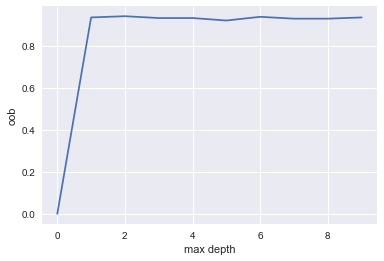

In [153]:
#include plots against a suitably-chosen range of values for these parameters
#n_estimators
def rfscore_maxdep(X,y,M=10):
    score = np.zeros(M)
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=0.4, random_state=0)
    
    for m in np.arange(1,M):
        value=m
        rf = RandomForestClassifier(n_jobs=20, n_estimators=10,max_depth=value, bootstrap=True, criterion='entropy',oob_score=True)
        rf.fit(X_train, y_train)
        preds = rf.predict(X_test)
        #pd.crosstab(y_test, preds, rownames=['actual'], 
           # colnames=['prediction'])
        score[value]=rf.oob_score_
    #return score

    plt.plot(range(M), score)
    plt.xlabel('max depth')
    plt.ylabel('oob')
    
rfscore_maxdep(X,y)

/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

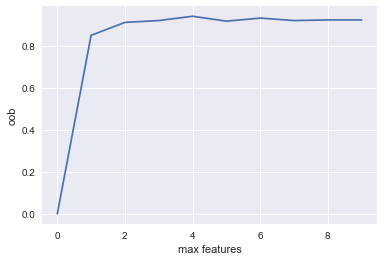

In [154]:
#include plots against a suitably-chosen range of values for these parameters
#n_estimators
def rfscore_maxfea(X,y,M=10):
    score = np.zeros(M)
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=0.4, random_state=0)
    
    for m in np.arange(1,M):
        value=m
        rf = RandomForestClassifier(n_jobs=20, n_estimators=10,max_depth=value,max_features=value, bootstrap=True, criterion='entropy',oob_score=True)
        rf.fit(X_train, y_train)
        preds = rf.predict(X_test)
        #pd.crosstab(y_test, preds, rownames=['actual'], 
           # colnames=['prediction'])
        score[value]=rf.oob_score_
    #return score

    plt.plot(range(M), score)
    plt.xlabel('max features')
    plt.ylabel('oob')
    
rfscore_maxfea(X,y)

I use oob score as measure of evidence since all of the classfier use bootstrap to split samples, so it makes sense to use oob score.
Here we find:
sensitivity to the parameters 
`max_features`, the number of variables considered for splitting at each step, from plot we find after max_feature-2, performance is very stable
`max_depth`, the maximum depth of the tree, we find after max depth=1 (n_estimator=10), performance is stable
`n_estimators`, the number of trees in the forest, we find after n_estimators>5, performance is very stable

## Question 4

Use a grid search to optimize the number of estimators and max_depth for a Gradient Boosted Decision tree using the Wisconsin breast cancer data. Plug this optimal ``max_depth`` into a *single* decision tree.  Does this single tree over-fit or under-fit the data? Repeat this for the Random Forest.  Construct a single decision tree using the ``max_depth`` which is optimal for the Random Forest.  Does this single tree over-fit or under-fit the data?

## gradient boosted decison tree

In [ ]:
# Write your work here
#optimize parameters: find best parameters for n_estimators and max_depth
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators':[20,100,200,300,400,500,1000,2000,3000],
              'max_depth': [1,2,3,4,5,6,7,8,9,10]
              }

est = GradientBoostingClassifier() #tree number=200 here

# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
gs_cv.best_params_


In [ ]:
#put these parameters in a single tree
est = GradientBoostingClassifier(n_estimators=1000, max_depth=1,
                                 random_state=0)
est.fit(X_train, y_train)



# predict class labels
pred = est.predict(X_test)

# score on test data (accuracy)
acc = est.score(X_test, y_test)
print('ACC: %.4f' % acc)


In [134]:
#overfit or undefit data?
#score from training data
est.train_score_

#compare test data score with train score, the test score and train score are similar, so we think this tree didn't overfit data


array([ 1.18565455,  1.07280753,  0.97688707,  0.89840981,  0.82819528,
        0.76924794,  0.71704458,  0.67046125,  0.62946929,  0.59395891,
        0.56036323,  0.53138277,  0.50523308,  0.48022251,  0.45918046,
        0.43867928,  0.4213816 ,  0.40532991,  0.39002575,  0.37611578,
        0.36403774,  0.35290663,  0.34266789,  0.33330908,  0.32367131,
        0.31504451,  0.30710307,  0.29928486,  0.29241476,  0.28510927,
        0.27858684,  0.27265605,  0.26685413,  0.26152183,  0.25611223,
        0.25356528,  0.24884408,  0.24430273,  0.24015   ,  0.23602745,
        0.23491422,  0.23027059,  0.22827991,  0.22440456,  0.22350873,
        0.22002816,  0.21660364,  0.21325369,  0.21251176,  0.20956811,
        0.20798915,  0.20459747,  0.20165802,  0.19906044,  0.19684562,
        0.19427665,  0.1919178 ,  0.18935767,  0.18693768,  0.18469095,
        0.18417312,  0.18233696,  0.18026415,  0.17827911,  0.17716709,
        0.1765567 ,  0.17469977,  0.17345724,  0.17153767,  0.16

## random forest

In [147]:
#random forest,find "best parameter" by grid search
param_grid = {
    'n_estimators':[20,100,200,300,400,500,1000,2000,3000],
              'max_depth': [1,2,3,4,5,6,7,8,9,10]
              }

rf=RandomForestClassifier()

# this may take some minutes
rf_cv = GridSearchCV(rf, param_grid, n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
rf_cv.best_params_


{'max_depth': 8, 'n_estimators': 200}

In [148]:

#put these parameters in a single tree
rf = RandomForestClassifier(n_estimators=200, max_depth=8,
                                 n_jobs=4)
rf.fit(X_train, y_train)

# predict class labels
pred = rf.predict(X_test)

# score on test data (accuracy)
acc = rf.score(X_test, y_test)
print('ACC: %.4f' % acc)

ACC: 0.9386


In [171]:
#overfit or undefit data?

#from test score, so we think this random forest did overfit data


AttributeError: 'RandomForestClassifier' object has no attribute 'train_score_'